# Detectron2: Train and export model

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_train_and_export_model.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Object-Detection-and-Image-Segmentation-with-Detectron2/blob/master/Detectron2_train_and_export_model.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

## Train on a custom dataset

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Before we can start training our model we need to download some dataset. In this case we will use a dataset with balloon images.

In [ ]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
!unzip balloon_dataset.zip > /dev/null

In order to use a dataset with Detectron2 we need to register it. For more information check out the [official documentation](https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset).

In [29]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

AssertionError: ignored

Now, let's fine-tune a pretrained FasterRCNN object detection model to detect our balloons.

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 70    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.DEVICE = 'cpu'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [32]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

predictor = DefaultPredictor(cfg)

R-50.pkl: 102MB [00:04, 22.9MB/s]                            


[07/18 20:19:42 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[07/18 20:19:42 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*  

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


In [ ]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=balloon_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

We can also evaluate its performance using AP metric implemented in COCO API.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

## Save config

In [ ]:
print(cfg.dump())

In [22]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

## Export model

In [ ]:
# https://github.com/onnx/onnx/issues/582#issuecomment-824263936
!pip install onnx==1.8.1
!pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
import argparse
import os
import onnx

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.export.api import Caffe2Tracer
from detectron2.model_zoo import get_config_file
output = "models"

os.makedirs(output, exist_ok=True)
# create a torch model

torch_model = build_model(cfg)
DetectionCheckpointer(torch_model).resume_or_load(cfg.MODEL.WEIGHTS)

# get a sample data

data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
first_batch = next(iter(data_loader))



In [26]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [34]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-07-18 20:21:54--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.82.56
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.82.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  74.5MB/s    in 3.2s    

2022-07-18 20:21:57 (74.5 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



### Export to caffe2

In [35]:
# convert and save caffe2 model
tracer = Caffe2Tracer(cfg, torch_model, first_batch)
caffe2_model = tracer.export_caffe2()
caffe2_model.save_protobuf(output)
# draw the caffe2 graph
caffe2_model.save_graph(os.path.join(output, "model.svg"), inputs=first_batch)

[07/18 20:22:11 d2.export.caffe2_export]: Exporting a Caffe2GeneralizedRCNN model via ONNX ... Some warnings from ONNX are expected and are usually not to worry about.


/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `add_node_names' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `add_node_names` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.7/dist-packages/torch/onnx/utils.py:269: UserWarning: `do_constant_folding' can be set to True only when 'operator_export_type' is `ONNX`. Since 'operator_export_type' is not set to 'ONNX', `do_constant_folding` argument will be ignored.
  "`{}` argument will be ignored.".format(arg_name, arg_name))
/usr/local/lib/python3.7/dist-packages/detectron2/export/c10.py:32: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert tensor.dim() == 2 an

[07/18 20:22:32 d2.export.caffe2_export]: ONNX export Done. Exported predict_net (before optimizations):
| type                   | input                                                                                                                                               | output                                                                                                              |
|:-----------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------|
| AliasWithName          | ['data']                                                                                                                                            | ['297']                                                                                                             |
| AliasWit

Try caffe2 model

In [36]:
from detectron2.export import Caffe2Model

model = Caffe2Model.load_protobuf(output)

In [37]:
import torch
torch.cuda.empty_cache()

im = first_batch[0]['image']

inputs = [{"image": im}]
outputs = model(inputs)

[07/18 20:24:11 d2.export.caffe2_inference]: Initializing ProtobufModel for: torch-jit-export_predict ...
[07/18 20:24:11 d2.export.caffe2_inference]: Running init_net once to fill the parameters ...


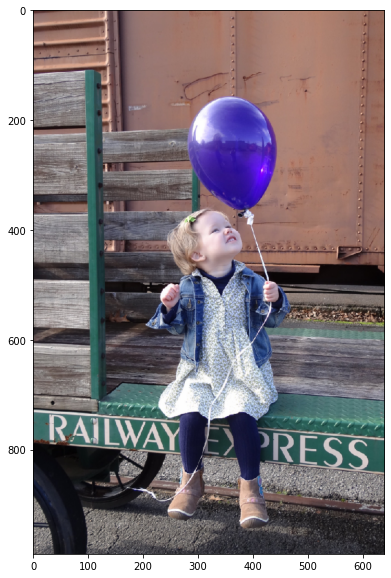

In [38]:
v = Visualizer(im.numpy().transpose(1, 2, 0), metadata=balloon_metadata, scale=0.8)
v = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

### Export to ONNX

In [ ]:
import torch
torch.cuda.empty_cache()
import onnx

onnx_model = tracer.export_onnx()
onnx.save(onnx_model, os.path.join(output, "model.onnx"))

### Export to torchscript

In [40]:
from detectron2.export.torchscript import dump_torchscript_IR

ts_model = tracer.export_torchscript()
ts_model.save(os.path.join(output, "model.ts"))
        
dump_torchscript_IR(ts_model, output)

[07/18 20:25:47 d2.export.api]: Tracing the model with torch.jit.trace ...


/usr/local/lib/python3.7/dist-packages/detectron2/export/c10.py:32: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert tensor.dim() == 2 and tensor.size(-1) in [4, 5, 6], tensor.size()
/usr/local/lib/python3.7/dist-packages/detectron2/export/c10.py:409: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if num_classes + 1 == class_logits.shape[1]:
/usr/local/lib/python3.7/dist-packages/detectron2/export/c10.py:418: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, 

In [ ]:
!ls -lah $output

total 548M
drwxr-xr-x 2 root root 4.0K Aug 13 06:51 .
drwxr-xr-x 1 root root 4.0K Aug 13 06:44 ..
-rw-r--r-- 1 root root 210M Aug 13 06:44 model_init.pb
-rw-r--r-- 1 root root 168M Aug 13 06:51 model.onnx
-rw-r--r-- 1 root root  23K Aug 13 06:44 model.pb
-rw-r--r-- 1 root root  71K Aug 13 06:44 model.pbtxt
-rw-r--r-- 1 root root 638K Aug 13 06:44 model.svg
-rw-r--r-- 1 root root 169M Aug 13 06:51 model.ts
-rw-r--r-- 1 root root 135K Aug 13 06:51 model_ts_code.txt
-rw-r--r-- 1 root root 260K Aug 13 06:51 model_ts_IR_inlined.txt
-rw-r--r-- 1 root root 1.1M Aug 13 06:51 model_ts_IR.txt
-rw-r--r-- 1 root root  13K Aug 13 06:51 model.txt
